In [1]:
import qif
import numpy as np
import pandas as pd
from causalgraphicalmodels import StructuralCausalModel, CausalGraphicalModel
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

In [14]:
# Graph functions
def node_function(x, p=0.9):
    if x == 0:
        return x
    else:
        return np.random.binomial(n=1, p=p)
    

def node_function_2(x1, x2, p=0.95):
    if x1 != x2:
        return np.random.binomial(n=1, p=1-p)
    elif x1 == x2:
        return np.random.binomial(n=1, p=p)
    

def node_function_3(x1, x2, x3, p=0.95):
    if x1 == x2 and x2 == x3:
        return np.random.binomial(n=1, p=p)
    else:
        return np.random.binomial(n=1, p=1-p)
    
    
def node_function_4(x, p=0.9):
    if x == 0:
        return np.random.binomial(n=1, p=p)
    else:
        return np.random.binomial(n=1, p=(1-p))
    

# Experiment functions
def run_experiment(graph, n_samples=1000, n_runs=100):
    n_runs = 100
    n_samples = 1000
    flows = []
    for i in range(n_runs):
        data = graph.sample(n_samples)
        bayes_leakage = qif.BayesLeakage(data)
        avg_dir_flow, avg_rev_flow = bayes_leakage.compute_flows(x='X', y='Y')
        flows.append([avg_dir_flow, avg_rev_flow])
        
    return flows


# Validation functions
def plot_flows(df):
    plt.figure(figsize=(10, 10))

    groups = df.groupby("label")
    for name, group in groups:
        plt.plot(group['reverse_flow'], group['direct_flow'], marker="o", linestyle="", label=name, alpha=0.5)
    plt.plot([0.95, 3], [0.95, 3], color='black', linewidth=0.5, linestyle='dashed')
    plt.xlabel("Reverse Flow", fontsize=14)
    plt.ylabel("Direct Flow", fontsize=14)
    plt.xlim([0.95, 2])
    plt.ylim([0.95, 2])
    plt.legend(fontsize=14)
    plt.show()

# Identifiable

## 3.8 A

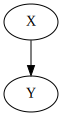

In [3]:
scm_38a = StructuralCausalModel({
    "X": lambda    n_samples: np.random.binomial(n=1, p=0.4, size=n_samples),
    "Y": lambda X, n_samples: np.array(list(map(node_function, X))),
})

scm_38a.cgm.draw()

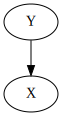

In [4]:
scm_38a1 = StructuralCausalModel({
    "Y": lambda    n_samples: np.random.binomial(n=1, p=0.4, size=n_samples),
    "X": lambda Y, n_samples: np.array(list(map(node_function, Y))),
})

scm_38a1.cgm.draw()

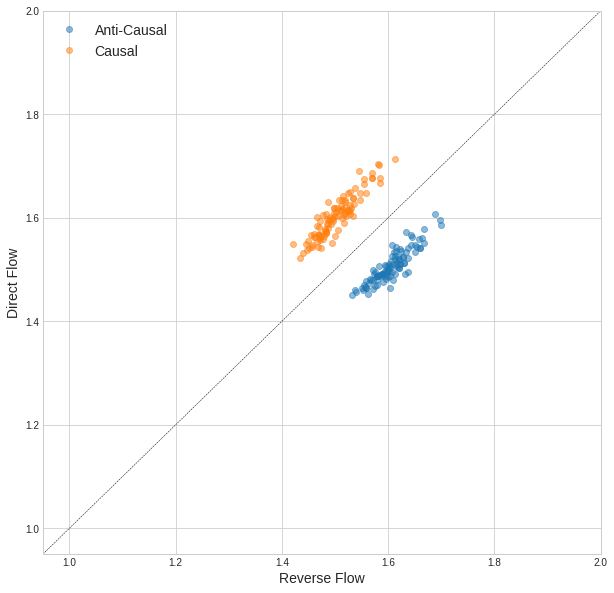

In [5]:
flows = run_experiment(scm_38a)
df = pd.DataFrame(flows, columns=['direct_flow', 'reverse_flow'])
df['label'] = 'Causal'

flows = run_experiment(scm_38a1)
df2 = pd.DataFrame(flows, columns=['direct_flow', 'reverse_flow'])
df2['label'] = 'Anti-Causal'

df = pd.concat([df, df2])
plot_flows(df)

In [15]:
scm_38a = StructuralCausalModel({
    "X": lambda    n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "Y": lambda X, n_samples: np.array(list(map(node_function_4, X, np.array([0.15] * n_samples)))),
})

data = scm_38a.sample(10000)
bayes_leakage = qif.BayesLeakage(data)
bayes_leakage.joint_distribution(x='X', y='Y')

Y,0,1
X,,
0,0.4154,0.0768
1,0.0796,0.4282


In [16]:
P = np.arange(0.00, 1.01, 0.01)
flows2 = []
for p in tqdm(P):
    for q in P:
        scm_38a = StructuralCausalModel({
            "X": lambda    n_samples: np.random.binomial(n=1, p=p, size=n_samples),
            "Y": lambda X, n_samples: np.array(list(map(node_function_4, X, np.array([q] * n_samples)))),
        })
        
        data = scm_38a.sample(1000)
        bayes_leakage = qif.BayesLeakage(data)
        avg_dir_flow, avg_rev_flow = bayes_leakage.compute_flows(x='X', y='Y')
        flows2.append([avg_dir_flow, avg_rev_flow, p, q])
        
df2 = pd.DataFrame(flows2, columns=['direct_flow', 'reverse_flow', 'p', 'q'])
df2['label'] = 'Causal'

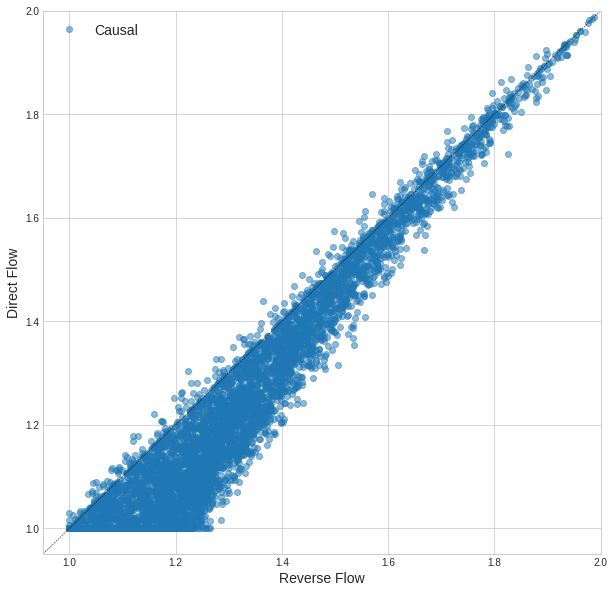

In [17]:
plot_flows(df2)

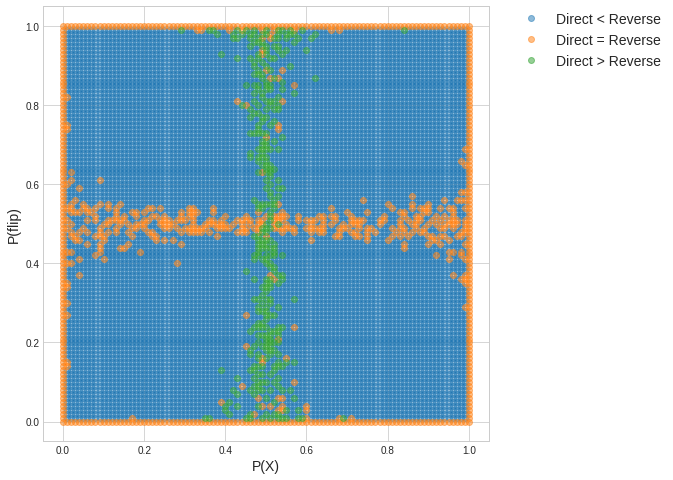

In [18]:
df2['flow_label'] = None
df2.loc[df2['direct_flow'] > df2['reverse_flow'], 'flow_label'] = 'Direct > Reverse'
df2.loc[df2['direct_flow'] < df2['reverse_flow'], 'flow_label'] = 'Direct < Reverse'
df2.loc[df2['direct_flow'] == df2['reverse_flow'], 'flow_label'] = 'Direct = Reverse'

plt.figure(figsize=(8, 8))
groups = df2.groupby("flow_label")
for name, group in groups:
    plt.plot(group['p'], group['q'], marker="o", linestyle="", label=name, alpha=0.5)
plt.xlabel("P(X)", fontsize=14)
plt.ylabel("P(flip)", fontsize=14)
plt.legend(fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [19]:
print("Direct > Reverse:", df2.query("direct_flow > reverse_flow").shape[0]/df2.shape[0])
print("Direct = Reverse:", df2.query("direct_flow == reverse_flow").shape[0]/df2.shape[0])
print("Direct < Reverse:", df2.query("direct_flow < reverse_flow").shape[0]/df2.shape[0])

Direct > Reverse: 0.03254582884030977
Direct = Reverse: 0.08009018723654544
Direct < Reverse: 0.8873639839231448


## 3.8 B

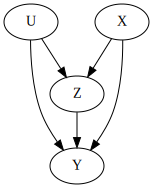

In [12]:
scm_38b = StructuralCausalModel({
    "X": lambda n_samples: np.random.binomial(n=1, p=0.4, size=n_samples),
    "Y": lambda X, Z, U, n_samples: np.array(list(map(node_function_3, X, Z, U))),
    "Z": lambda X, U, n_samples: np.array(list(map(node_function_2, X, U))),
    "U": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples)
})

scm_38b.cgm.draw()

P(U,X,Z,Y) = P(U)P(X)P(Z|U,X)P(Y|X,U,Z)
P(Y|X) = Sum_z P(Y|X,Z)P(Z)

In [14]:
def run_experiment_scm38b(x, y):
    P = np.arange(0.0, 1.1, 0.1)
    flows2 = []
    for p in tqdm(P):
        for q1 in P:
            for k in P:
                for q2 in P:
                    scm_38b = StructuralCausalModel({
                        "X": lambda n_samples: np.random.binomial(n=1, p=p, size=n_samples),
                        "Y": lambda X, Z, U, n_samples: np.array(list(map(node_function_3, X, Z, U, np.array([q1] * n_samples)))),
                        "Z": lambda X, U, n_samples: np.array(list(map(node_function_2, X, U, np.array([q2] * n_samples)))),
                        "U": lambda n_samples: np.random.binomial(n=1, p=k, size=n_samples)
                    })

                    data = scm_38b.sample(1000)
                    bayes_leakage = qif.BayesLeakage(data)
                    avg_dir_flow, avg_rev_flow = bayes_leakage.compute_flows(x=x, y=y)
                    flows2.append([avg_dir_flow, avg_rev_flow])
    df2 = pd.DataFrame(flows2, columns=['direct_flow', 'reverse_flow'])
    df2['label'] = 'Causal'
    return df2

### Z -> Y

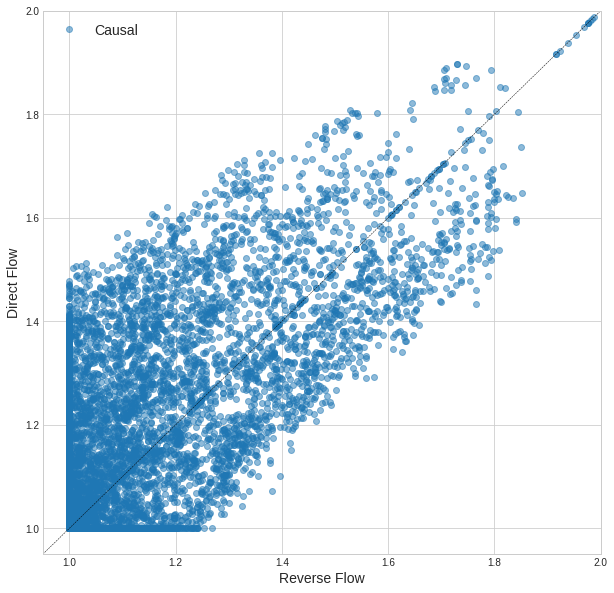

In [17]:
df = run_experiment_scm38b(x='Z', y='Y')
plot_flows(df)

In [18]:
print("Direct > Reverse:", df.query("direct_flow > reverse_flow").shape[0]/df.shape[0])
print("Direct = Reverse:", df.query("direct_flow == reverse_flow").shape[0]/df.shape[0])
print("Direct < Reverse:", df.query("direct_flow < reverse_flow").shape[0]/df.shape[0])

Direct > Reverse: 0.5070691892630285
Direct = Reverse: 0.28071853015504405
Direct < Reverse: 0.21221228058192745


### X -> Y

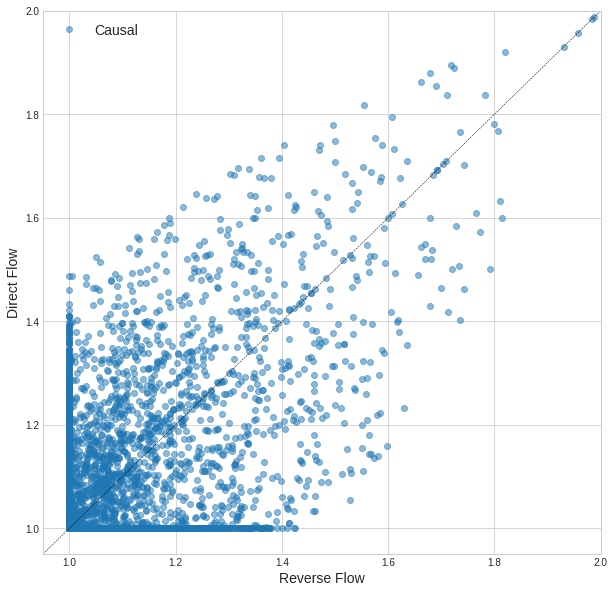

In [19]:
df = run_experiment_scm38b(x='X', y='Y')
plot_flows(df)

In [20]:
print("Direct > Reverse:", df.query("direct_flow > reverse_flow").shape[0]/df.shape[0])
print("Direct = Reverse:", df.query("direct_flow == reverse_flow").shape[0]/df.shape[0])
print("Direct < Reverse:", df.query("direct_flow < reverse_flow").shape[0]/df.shape[0])

Direct > Reverse: 0.1672016938733693
Direct = Reverse: 0.612867973499078
Direct < Reverse: 0.21993033262755277


### X -> Z

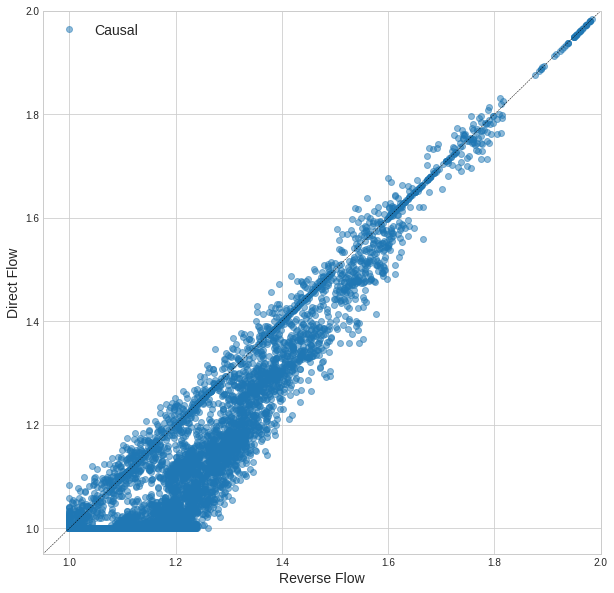

In [21]:
df = run_experiment_scm38b(x='X', y='Z')
plot_flows(df)

In [22]:
print("Direct > Reverse:", df.query("direct_flow > reverse_flow").shape[0]/df.shape[0])
print("Direct = Reverse:", df.query("direct_flow == reverse_flow").shape[0]/df.shape[0])
print("Direct < Reverse:", df.query("direct_flow < reverse_flow").shape[0]/df.shape[0])

Direct > Reverse: 0.03879516426473602
Direct = Reverse: 0.29984290690526605
Direct < Reverse: 0.661361928829998


## 3.8 E

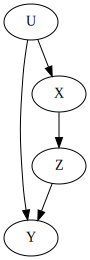

In [23]:
scm_38e = StructuralCausalModel({
    "X": lambda U, n_samples: np.random.binomial(n=1,p=0.7 * U, size=n_samples),
    "Y": lambda Z, U, n_samples: np.array(list(map(node_function_2, Z, U))),
    "Z": lambda X, n_samples: np.array(list(map(node_function, X))),
    "U": lambda    n_samples: np.random.binomial(n=1, p=0.2, size=n_samples)
})

scm_38e.cgm.draw()

In [24]:
def run_experiment_scm38e(x, y):
    P = np.arange(0.0, 1.1, 0.1)
    flows2 = []
    for p in tqdm(P):
        for q1 in P:
            for k in P:
                for q2 in P:
                    scm_38e = StructuralCausalModel({
                        "X": lambda U, n_samples: np.random.binomial(n=1,p=p * U, size=n_samples),
                        "Y": lambda Z, U, n_samples: np.array(list(map(node_function_2, Z, U, np.array([q1] * n_samples)))),
                        "Z": lambda X, n_samples: np.array(list(map(node_function, X, np.array([q2] * n_samples)))),
                        "U": lambda    n_samples: np.random.binomial(n=1, p=k, size=n_samples)
                    })

                    data = scm_38e.sample(1000)
                    bayes_leakage = qif.BayesLeakage(data)
                    avg_dir_flow, avg_rev_flow = bayes_leakage.compute_flows(x=x, y=y)
                    flows2.append([avg_dir_flow, avg_rev_flow])

    df2 = pd.DataFrame(flows2, columns=['direct_flow', 'reverse_flow'])
    df2['label'] = 'Causal'
    return df2

### X -> Z

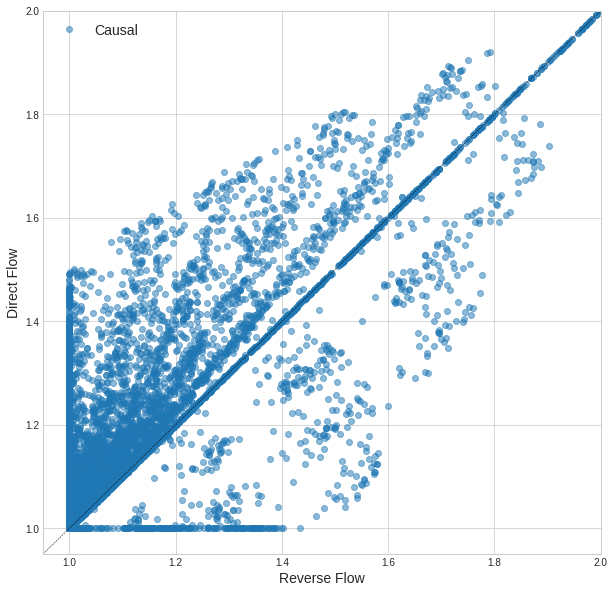

In [25]:
df = run_experiment_scm38e(x='X', y='Z')
plot_flows(df)

In [26]:
print("Direct > Reverse:", df.query("direct_flow > reverse_flow").shape[0]/df.shape[0])
print("Direct = Reverse:", df.query("direct_flow == reverse_flow").shape[0]/df.shape[0])
print("Direct < Reverse:", df.query("direct_flow < reverse_flow").shape[0]/df.shape[0])

Direct > Reverse: 0.5755071374906086
Direct = Reverse: 0.37811624889010315
Direct < Reverse: 0.0463766136192883


### Z -> Y

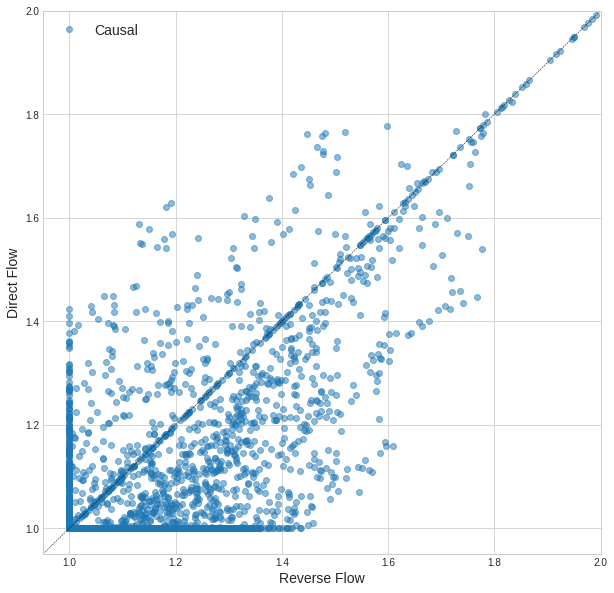

In [27]:
df = run_experiment_scm38e(x='Z', y='Y')
plot_flows(df)

In [28]:
print("Direct > Reverse:", df.query("direct_flow > reverse_flow").shape[0]/df.shape[0])
print("Direct = Reverse:", df.query("direct_flow == reverse_flow").shape[0]/df.shape[0])
print("Direct < Reverse:", df.query("direct_flow < reverse_flow").shape[0]/df.shape[0])

Direct > Reverse: 0.03326275527627894
Direct = Reverse: 0.6593128884639028
Direct < Reverse: 0.30742435625981834


### X -> Y

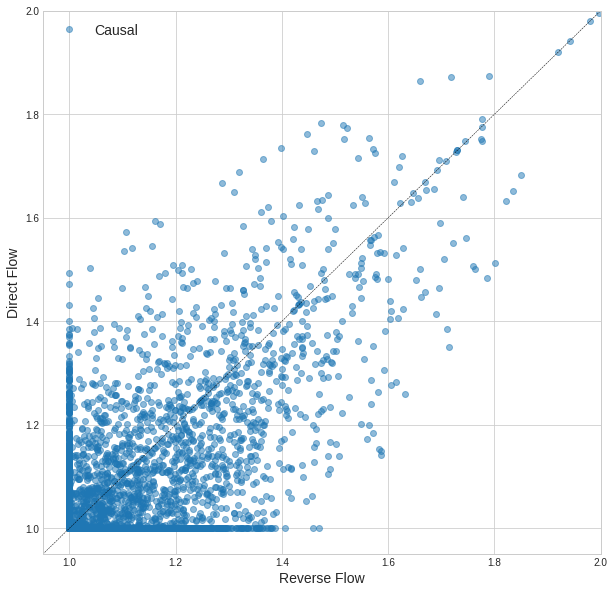

In [29]:
df = run_experiment_scm38e(x='X', y='Y')
plot_flows(df)

In [30]:
print("Direct > Reverse:", df.query("direct_flow > reverse_flow").shape[0]/df.shape[0])
print("Direct = Reverse:", df.query("direct_flow == reverse_flow").shape[0]/df.shape[0])
print("Direct < Reverse:", df.query("direct_flow < reverse_flow").shape[0]/df.shape[0])

Direct > Reverse: 0.09029437879926235
Direct = Reverse: 0.5561095553582406
Direct < Reverse: 0.3535960658424971


# Unidentifiable

## 3.7 A

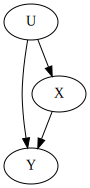

In [31]:
scm_37a = StructuralCausalModel({
    "X": lambda U, n_samples: np.array(list(map(node_function, U))),
    "Y": lambda X, U, n_samples: np.array(list(map(node_function_2, X, U))),
    "U": lambda    n_samples: np.random.binomial(n=1, p=0.4, size=n_samples)
})

scm_37a.cgm.draw()

In [34]:
def run_experiment_scm37a(x, y):
    P = np.arange(0.0, 1.02, 0.02)
    flows2 = []
    for p in tqdm(P):
        for q1 in P:
            scm_37a = StructuralCausalModel({
                "X": lambda U, n_samples: np.array(list(map(node_function, U))),
                "Y": lambda X, U, n_samples: np.array(list(map(node_function_2, X, U, np.array([q1] * n_samples)))),
                "U": lambda    n_samples: np.random.binomial(n=1, p=p, size=n_samples)
            })

            data = scm_37a.sample(1000)
            bayes_leakage = qif.BayesLeakage(data)
            avg_dir_flow, avg_rev_flow = bayes_leakage.compute_flows(x=x, y=y)
            flows2.append([avg_dir_flow, avg_rev_flow])

    df2 = pd.DataFrame(flows2, columns=['direct_flow', 'reverse_flow'])
    df2['label'] = 'Causal'
    return df2

### X-> Y

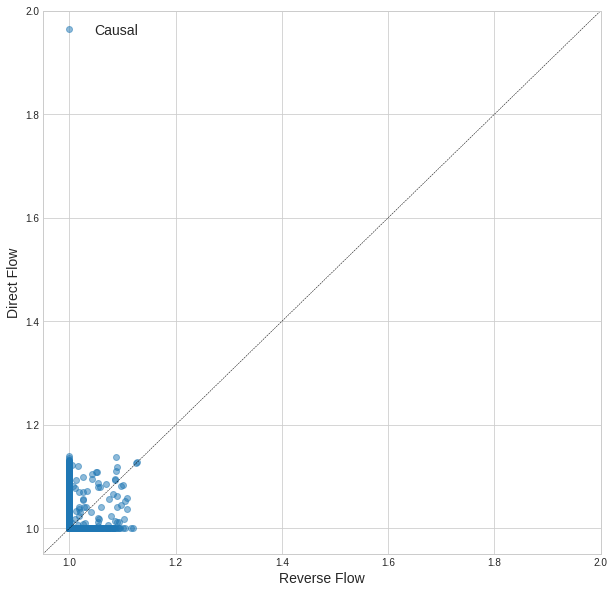

In [35]:
df = run_experiment_scm37a(x='X', y='Y')
plot_flows(df)

In [36]:
print("Direct > Reverse:", df.query("direct_flow > reverse_flow").shape[0]/df.shape[0])
print("Direct = Reverse:", df.query("direct_flow == reverse_flow").shape[0]/df.shape[0])
print("Direct < Reverse:", df.query("direct_flow < reverse_flow").shape[0]/df.shape[0])

Direct > Reverse: 0.16724336793540945
Direct = Reverse: 0.724721261053441
Direct < Reverse: 0.10803537101114956


## 3.7 B

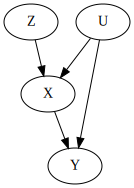

In [40]:
scm_37b = StructuralCausalModel({
    "Z": lambda    n_samples: np.random.binomial(n=1, p=0.6, size=n_samples),
    "U": lambda    n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "X": lambda U, Z, n_samples: np.array(list(map(node_function_2, U, Z))),
    "Y": lambda X, U, n_samples: np.array(list(map(node_function_2, X, U)))
})

scm_37b.cgm.draw()

In [48]:
def run_experiment_scm37b(x, y):
    P = np.arange(0.0, 1.1, 0.1)
    flows2 = []
    for p in tqdm(P):
        for q1 in P:
            for k in P:
                for q2 in P:
                    scm_37b = StructuralCausalModel({
                        "Z": lambda    n_samples: np.random.binomial(n=1, p=p, size=n_samples),
                        "U": lambda    n_samples: np.random.binomial(n=1, p=k, size=n_samples),
                        "X": lambda U, Z, n_samples: np.array(list(map(node_function_2, U, Z, np.array([q1] * n_samples)))),
                        "Y": lambda X, U, n_samples: np.array(list(map(node_function_2, X, U, np.array([q2] * n_samples))))
                    })
                    
                    data = scm_37b.sample(1000)
                    bayes_leakage = qif.BayesLeakage(data)
                    avg_dir_flow, avg_rev_flow = bayes_leakage.compute_flows(x=x, y=y)
                    flows2.append([avg_dir_flow, avg_rev_flow])

    df2 = pd.DataFrame(flows2, columns=['direct_flow', 'reverse_flow'])
    df2['label'] = 'Causal'
    return df2

### X-> Y

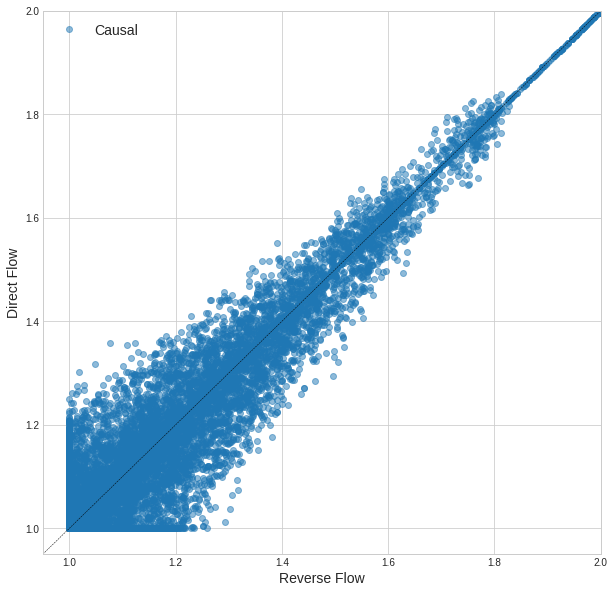

In [39]:
df = run_experiment_scm37b(x='X', y='Y')
plot_flows(df)

In [41]:
print("Direct > Reverse:", df.query("direct_flow > reverse_flow").shape[0]/df.shape[0])
print("Direct = Reverse:", df.query("direct_flow == reverse_flow").shape[0]/df.shape[0])
print("Direct < Reverse:", df.query("direct_flow < reverse_flow").shape[0]/df.shape[0])

Direct > Reverse: 0.386449013045557
Direct = Reverse: 0.23229287616966054
Direct < Reverse: 0.38125811078478244


### Z -> X

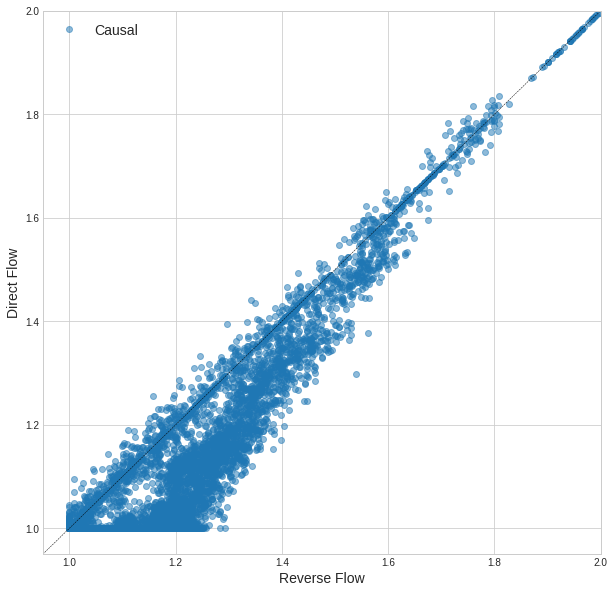

In [42]:
df = run_experiment_scm37b(x='Z', y='X')
plot_flows(df)

In [43]:
print("Direct > Reverse:", df.query("direct_flow > reverse_flow").shape[0]/df.shape[0])
print("Direct = Reverse:", df.query("direct_flow == reverse_flow").shape[0]/df.shape[0])
print("Direct < Reverse:", df.query("direct_flow < reverse_flow").shape[0]/df.shape[0])

Direct > Reverse: 0.03818045215490745
Direct = Reverse: 0.30469230243835804
Direct < Reverse: 0.6571272454067345


### Z -> Y

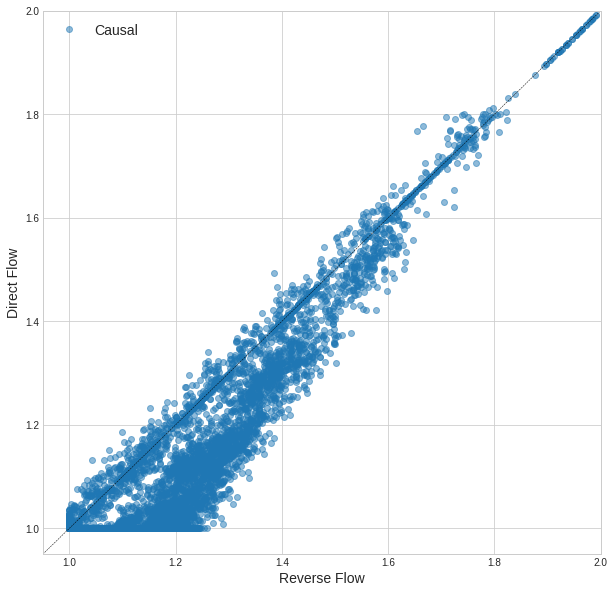

In [44]:
df = run_experiment_scm37b(x='Z', y='Y')
plot_flows(df)

In [45]:
print("Direct > Reverse:", df.query("direct_flow > reverse_flow").shape[0]/df.shape[0])
print("Direct = Reverse:", df.query("direct_flow == reverse_flow").shape[0]/df.shape[0])
print("Direct < Reverse:", df.query("direct_flow < reverse_flow").shape[0]/df.shape[0])

Direct > Reverse: 0.04159551943173281
Direct = Reverse: 0.3053070145481866
Direct < Reverse: 0.6530974660200806


## 3.7 C

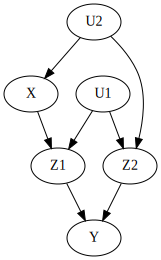

In [3]:
scm_37c = StructuralCausalModel({
    "X": lambda U2, n_samples: np.array(list(map(node_function, U2))),
    "Y": lambda Z1, Z2, n_samples: np.array(list(map(node_function_2, Z1, Z2))),
    "U1": lambda    n_samples: np.random.binomial(n=1, p=0.7, size=n_samples),
    "Z1": lambda X, U1, n_samples: np.array(list(map(node_function_2, 1-X, U1))),
    "U2": lambda    n_samples: np.random.binomial(n=1, p=0.9, size=n_samples),
    "Z2": lambda U1, U2, n_samples: np.array(list(map(node_function_2, U1, U2)))
})

scm_37c.cgm.draw()

In [4]:
def run_experiment_scm37c(x, y):
    P = np.arange(0.0, 1.2, 0.2)
    flows2 = []
    for p in tqdm(P):
        for q1 in P:
            for k in P:
                for q2 in P:
                    for q3 in P:
                        for q4 in P:
                            scm_37c = StructuralCausalModel({
                                "X": lambda U2, n_samples: np.array(list(map(node_function, U2, np.array([p] * n_samples)))),
                                "Y": lambda Z1, Z2, n_samples: np.array(list(map(node_function_2, Z1, Z2, np.array([k] * n_samples)))),
                                "U1": lambda    n_samples: np.random.binomial(n=1, p=q1, size=n_samples),
                                "Z1": lambda X, U1, n_samples: np.array(list(map(node_function_2, 1-X, U1, np.array([q2] * n_samples)))),
                                "U2": lambda    n_samples: np.random.binomial(n=1, p=q3, size=n_samples),
                                "Z2": lambda U1, U2, n_samples: np.array(list(map(node_function_2, U1, U2, np.array([q4] * n_samples))))
                            })

                            data = scm_37c.sample(1000)
                            bayes_leakage = qif.BayesLeakage(data)
                            avg_dir_flow, avg_rev_flow = bayes_leakage.compute_flows(x=x, y=y)
                            flows2.append([avg_dir_flow, avg_rev_flow])

    df2 = pd.DataFrame(flows2, columns=['direct_flow', 'reverse_flow'])
    df2['label'] = 'Causal'
    return df2

### X -> Y

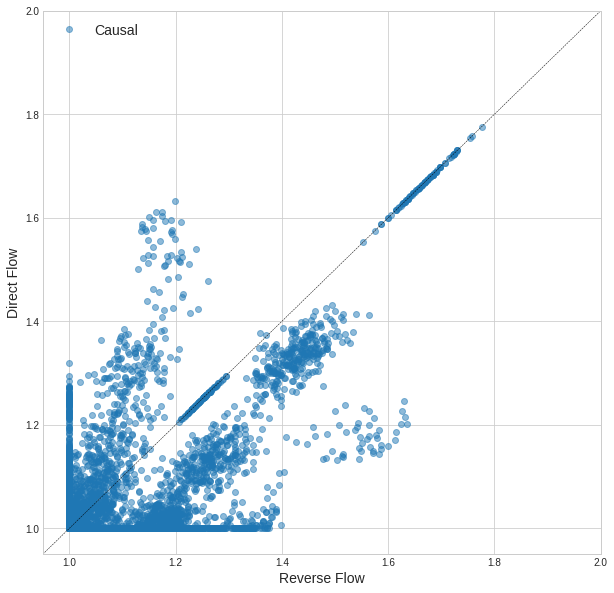

In [5]:
df = run_experiment_scm37c(x='X', y='Y')
plot_flows(df)

In [6]:
print("Direct > Reverse:", df.query("direct_flow > reverse_flow").shape[0]/df.shape[0])
print("Direct = Reverse:", df.query("direct_flow == reverse_flow").shape[0]/df.shape[0])
print("Direct < Reverse:", df.query("direct_flow < reverse_flow").shape[0]/df.shape[0])

Direct > Reverse: 0.031035665294924554
Direct = Reverse: 0.7252657750342936
Direct < Reverse: 0.24369855967078188


### Z1 -> Y

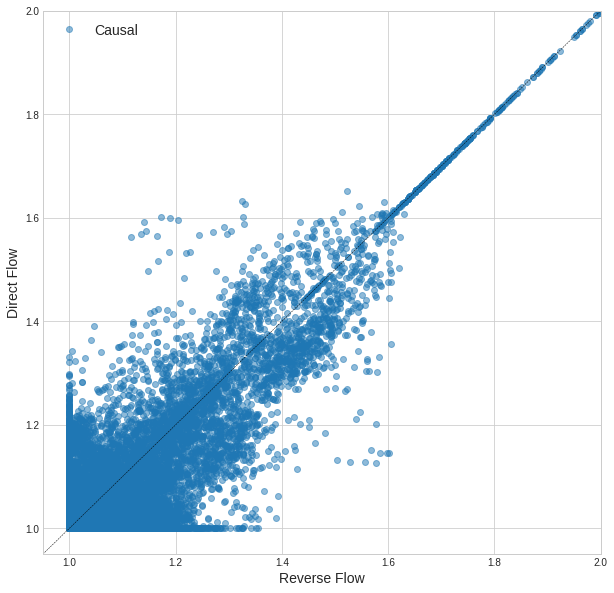

In [51]:
df = run_experiment_scm37c(x='Z1', y='Y')
plot_flows(df)

In [52]:
print("Direct > Reverse:", df.query("direct_flow > reverse_flow").shape[0]/df.shape[0])
print("Direct = Reverse:", df.query("direct_flow == reverse_flow").shape[0]/df.shape[0])
print("Direct < Reverse:", df.query("direct_flow < reverse_flow").shape[0]/df.shape[0])

Direct > Reverse: 0.17916237997256515
Direct = Reverse: 0.4774305555555556
Direct < Reverse: 0.3434070644718793
